In [1]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from numpy import sort
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/232597
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine quality dataset",
                                  labels=["quality"],
                                  query=query)

In [236]:
from sklearn.ensemble import RandomForestRegressor

# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn RandomForestRegressor algorithm using our features (X_train) and labels (y_train)
model = RandomForestRegressor(random_state=42, min_samples_split=7, n_estimators=50, max_depth=10, ccp_alpha=0.001, min_impurity_decrease=0.0001)
model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(ccp_alpha=0.001, max_depth=10,
                      min_impurity_decrease=0.0001, min_samples_split=7,
                      n_estimators=50, random_state=42)

In [237]:
# Evaluate model performance using the features from the test set (X_test) and round the predicted values.
y_pred = np.round(model.predict(X_test))
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [238]:
print(accuracy_score(y_test, y_pred))

0.5628517823639775


In [239]:
y_train['quality'].value_counts()

quality
6    1878
5    1380
7     693
4     169
8     117
3      23
9       3
Name: count, dtype: int64

In [240]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}, '5': {'precision': 0.6206896551724138, 'recall': 0.624, 'f1-score': 0.6223404255319148, 'support': 375.0}, '6': {'precision': 0.5358361774744027, 'recall': 0.6993318485523385, 'f1-score': 0.6067632850241547, 'support': 449.0}, '7': {'precision': 0.5148514851485149, 'recall': 0.3170731707317073, 'f1-score': 0.3924528301886792, 'support': 164.0}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 32.0}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, 'accuracy': 0.5628517823639775, 'macro avg': {'precision': 0.23876818825647592, 'recall': 0.23434357418343515, 'f1-score': 0.23165093439210693, 'support': 1066.0}, 'weighted avg': {'precision': 0.5232501950656834, 'recall': 0.5628517823639775, 'f1-score': 0.5348748955921735, 'support': 1066.0}}


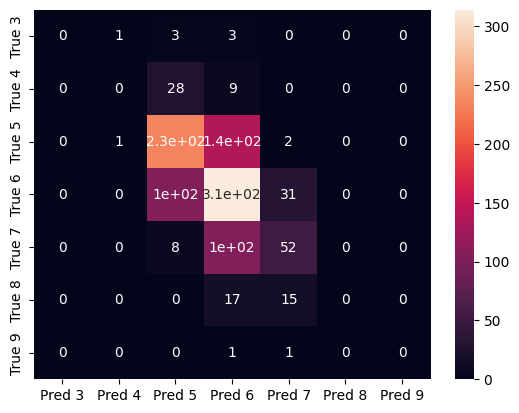

In [241]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True 3', 'True 4', 'True 5', 'True 6', 'True 7', 'True 8', 'True 9'],
                     ['Pred 3', 'Pred 4', 'Pred 5', 'Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [242]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/28114 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/844497 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1127 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/232597/models/wine_model/1


Model(name: 'wine_model', version: 1)